### Qiskit Primitives: Sampler and Estimator
Understanding the fundamental building blocks for quantum computation using Qiskit primitives

There are currently 2 supported Qiskit primitives: **Sampler** and **Estimator**.

1) **Sampler**: Calculate the quasi-probabilities of bitstrings form quantum circuits.
    - Quantum circuits $\psi_i(\theta)$.
    - Parameter values: $\theta_k$.


2) **Estimator**: Estimate expectation values of quantum circuits and observables. 
    - Quantum circuits $\psi_i(\theta)$. A list of (parameterized) quantum circuits.
    - Observables $H_j$.
    - Parameter values $\theta_k$. A list of values to be bound to the parameters of th quantum circuits.

------------------

### Sampler Example

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_aer.primitives import Estimator as AerEstimator 
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator, Sampler
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from token_file import token

In [2]:
# Sampler Primitive Basic Example
def create_parameterized_circuit():
    """Creates a simple parameterized circuit using RY rotation"""
    theta = Parameter('theta')
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)  # Parameterized rotation
    qc.measure_all()
    return qc, theta

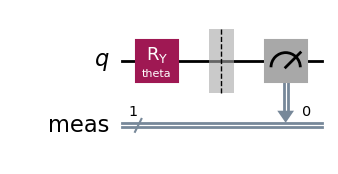

In [3]:
# Create and visualize circuit
qc, theta = create_parameterized_circuit()
qc.draw('mpl')  

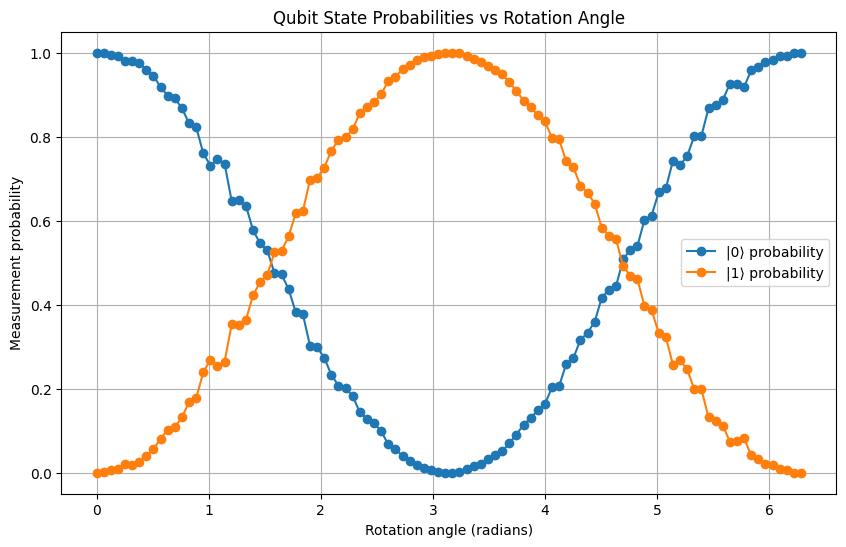

In [4]:
# Parameter
phases = np.linspace(0, 2*np.pi, 100)
individual_phases = [[ph] for ph in phases]

# Execute with AerSampler
aer_sampler = AerSampler()
result = aer_sampler.run(
    [qc]*len(individual_phases),
    parameter_values=individ<ual_phases
).result()

# Process and visualize results
prob_values_0 = [dist.get(0, 0) for dist in result.quasi_dists]
prob_values_1 = [dist.get(1, 0) for dist in result.quasi_dists]


plt.figure(figsize=(10, 6))
plt.plot(phases, prob_values_0, 'o-', label='|0⟩ probability')
plt.plot(phases, prob_values_1, 'o-', label='|1⟩ probability')
plt.xlabel('Rotation angle (radians)')
plt.ylabel('Measurement probability')
plt.title('Qubit State Probabilities vs Rotation Angle')
plt.legend()
plt.grid(True)
plt.show()


--------------------------

### execute on real backend

In [5]:
def setup_quantum_backend(token):
    service = QiskitRuntimeService(channel="ibm_quantum", token=token)
    backend = service.least_busy(
        min_num_qubits=1,
        operational=True,
        simulator=False
    )
    print(f"Selected backend: {backend.name}")
    return backend


backend = setup_quantum_backend(token)
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_hw = pm.run(qc)  #transpile circuit for hardware

Selected backend: ibm_brisbane


In [10]:
def run_on_hardware(circuit, values, backend):

    with Session(backend=backend) as session:
        sampler = Sampler(mode=session)
        
        # Create list of (circuit, parameter_values) tuples
        pubs = [(circuit, [v]) for v in values]
        
        # Submit job using new interface
        job = sampler.run(pubs, shots=1000)
        result = job.result()
    return result

#use fewer points for hardware execution to save time
hw_phases = np.linspace(0, 2*np.pi, 10)

try:
    hw_result = run_on_hardware(qc_hw, hw_phases, backend)
    
    prob_values_0_hw = []
    prob_values_1_hw = []
    
    # extract probabilities from each pub result
    for pub_result in hw_result:
        counts = pub_result.data.meas.get_counts()
        total_shots = sum(counts.values())
        prob_values_0_hw.append(counts.get('0', 0) / total_shots)
        prob_values_1_hw.append(counts.get('1', 0) / total_shots)

    print(prob_values_0_hw)
    print(prob_values_1_hw)

        
except Exception as e:
    print(f"Hardware execution failed: {str(e)}")

[0.993, 0.874, 0.594, 0.232, 0.034, 0.037, 0.286, 0.616, 0.876, 0.996]
[0.007, 0.126, 0.406, 0.768, 0.966, 0.963, 0.714, 0.384, 0.124, 0.004]


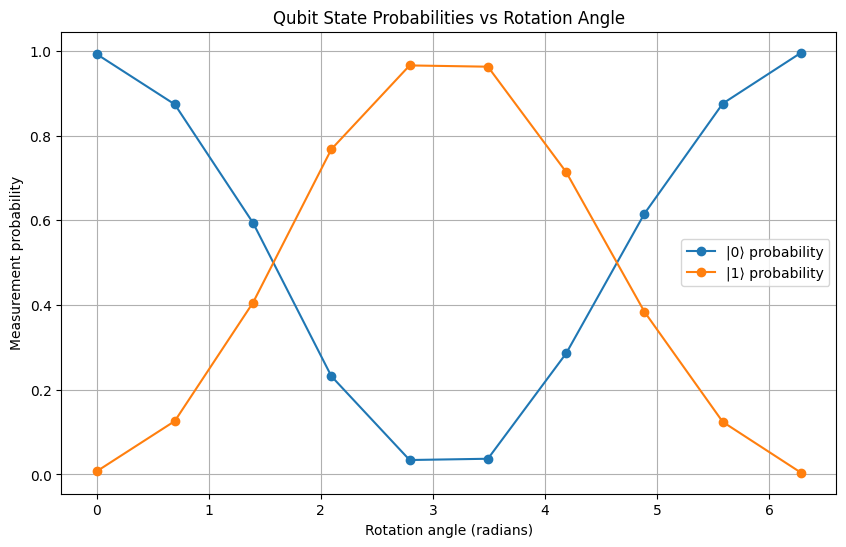

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(hw_phases, prob_values_0_hw, 'o-', label='|0⟩ probability')
plt.plot(hw_phases, prob_values_1_hw, 'o-', label='|1⟩ probability')
plt.xlabel('Rotation angle (radians)')
plt.ylabel('Measurement probability')
plt.title('Qubit State Probabilities vs Rotation Angle')
plt.legend()
plt.grid(True)
plt.show()

-------------------

### Estimator example

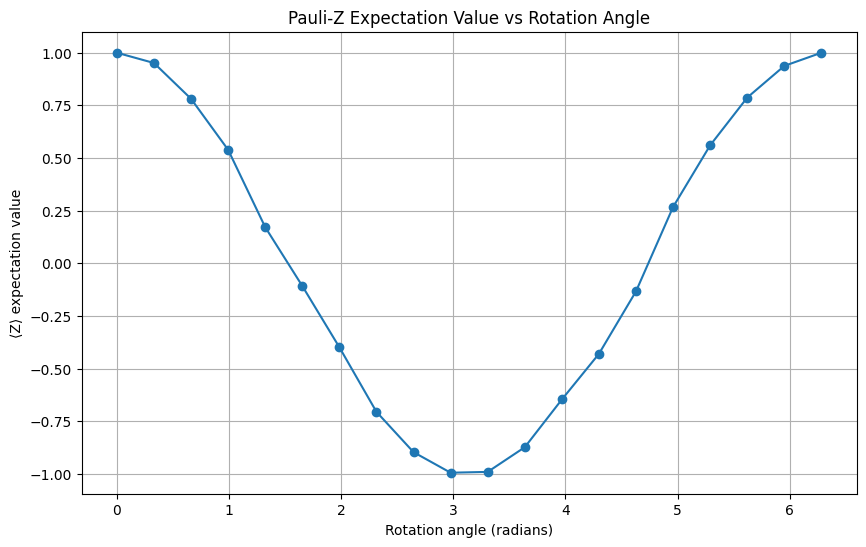

In [20]:
def create_estimator_circuit():
    """Create a circuit for estimator demonstration"""
    theta = Parameter('theta')
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    return qc, theta


observable = SparsePauliOp('Z')

qc_est, theta_est = create_estimator_circuit()
estimator = AerEstimator()

#calculate expectation values
phases_est = np.linspace(0, 2*np.pi, 20)
expectation_values = []

for phase in phases_est:
    result = estimator.run(
        qc_est, 
        observable, 
        parameter_values=[[phase]]
    ).result()
    expectation_values.append(float(result.values[0]))

# plot
plt.figure(figsize=(10, 6))
plt.plot(phases_est, expectation_values, 'o-')
plt.xlabel('Rotation angle (radians)')
plt.ylabel('⟨Z⟩ expectation value')
plt.title('Pauli-Z Expectation Value vs Rotation Angle')
plt.grid(True)
plt.show()

### run extimator on real hardware

In [21]:
def setup_quantum_backend(token):
    service = QiskitRuntimeService(channel="ibm_quantum", token=token)
    backend = service.least_busy(
        min_num_qubits=1,
        operational=True,
        simulator=False
    )
    print(f"Selected backend: {backend.name}")
    return backend


backend = setup_quantum_backend(token)
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

# same circuit as with estimator
qc_est = pm.run(qc)  #transpile circuit for hardware

Selected backend: ibm_kyiv


In [23]:
def run_on_hardware(backend):
    
    #with Session(backend=backend) as session:
    estimator = Estimator(backend, options={"default_shots": int(1e4)})
    observable = SparsePauliOp('Z').apply_layout(qc_est.layout)
    job = estimator.run([(qc_est, observable, phases_est)])
    # Get results for the first (and only) PUB
    pub_result = job.result()[0]
    print(f">>> Expectation values: {pub_result.data.evs}")
    print(f">>> Standard errors: {pub_result.data.stds}")
    print(f">>> Metadata: {pub_result.metadata}")
        
    return result


try:
    hw_result = run_on_hardware(backend)
    expectation_values = []
    

        
except Exception as e:
    print(f"Hardware execution failed: {str(e)}")

>>> Expectation values: [ 0.95487416  0.92303167  0.78885263  0.54232366  0.2475303  -0.07830449
 -0.39853179 -0.66508748 -0.85333867 -0.96709046 -0.96428672 -0.87376593
 -0.66989389 -0.4021366  -0.09833121  0.22229663  0.52990709  0.77643606
  0.92903969  0.98331211]
>>> Standard errors: [0.01046639 0.0055174  0.00608201 0.00828287 0.00954981 0.01260079
 0.01008571 0.00689735 0.00670639 0.00292095 0.00385009 0.00601776
 0.00742103 0.00958271 0.01060644 0.01031408 0.01074932 0.0071043
 0.00368084 0.00262001]
>>> Metadata: {'shots': 10016, 'target_precision': 0.01, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32}


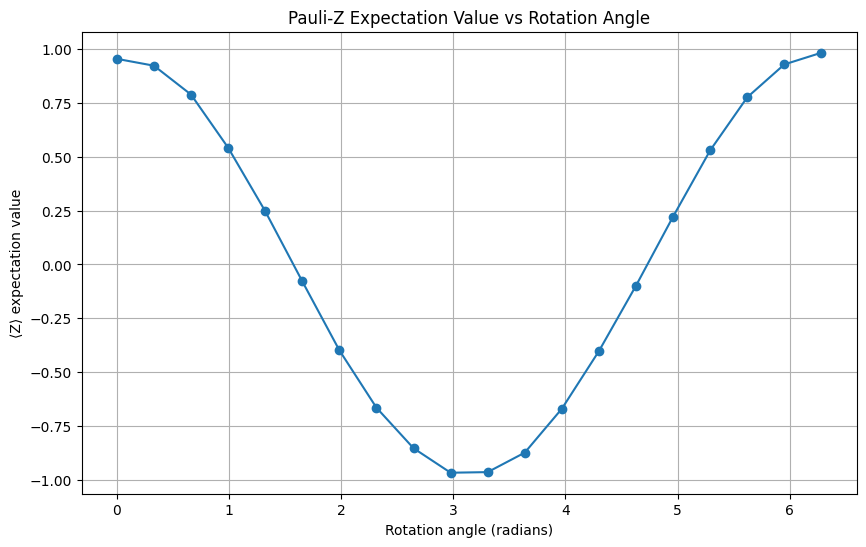

In [28]:
expectation_values =  [0.95487416,  0.92303167,  0.78885263,  0.54232366, 0.2475303, -0.07830449,
 -0.39853179, -0.66508748, -0.85333867, -0.96709046, -0.96428672, -0.87376593,
 -0.66989389, -0.4021366, -0.09833121, 0.22229663, 0.52990709, 0.77643606,
  0.92903969,  0.98331211]
plt.figure(figsize=(10, 6))
plt.plot(phases_est, expectation_values, 'o-')
plt.xlabel('Rotation angle (radians)')
plt.ylabel('⟨Z⟩ expectation value')
plt.title('Pauli-Z Expectation Value vs Rotation Angle')
plt.grid(True)
plt.show()